In [1]:
%%capture
!pip install datasets torch torchvision torchaudio transformers evaluate numpy rouge_score tensorboard matplotlib accelerate

In [2]:
%%writefile multi-gpu-train-fsdp.py
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, AutoModelForCausalLM, EarlyStoppingCallback
import evaluate
import torch
from torch.optim import Adam
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed.fsdp import FullyShardedDataParallel as FSDP
from torch.distributed.fsdp.wrap import size_based_auto_wrap_policy
from torch.distributed.fsdp.wrap import transformer_auto_wrap_policy
from torch.utils.data import DataLoader, DistributedSampler
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import gc
import numpy as np
from functools import partial

rouge_metric = evaluate.load("rouge")

os.environ['NCCL_SOCKET_IFNAME'] = 'eth0'
os.environ['NCCL_DEBUG'] = 'WARN'
os.environ['NCCL_TIMEOUT'] = '3600'

MODEL_NAME = "facebook/mbart-large-50"
MAX_LEN = 512
TOTAL_BACTH_SIZE = 16
TRAIN_BATCH_SIZE = 2
VAL_BATCH_SIZE = 2
EPOCHS = 3
LEARNING_RATE = 2e-5
CACHE_DATASET = "./datas/summary"
CACHE_MODEL = f"./models/{MODEL_NAME}"
LOG_DIR = f"./logs/{MODEL_NAME}"
SIZE = 200
TRAIN_SIZE = int(SIZE * 0.8)

dataset = load_dataset("nhantruongcse/summary-vietnamese-news")

def preprocessing(example_batch):
    inputs = [content for content in example_batch['Content']]
    
    input_encodings = tokenizer(
        inputs,
        max_length=MAX_LEN,
        truncation=True,
        padding="max_length",
        return_tensors='pt'
    )
    
    target_encodings = tokenizer(
        example_batch['Summary'],
        max_length=MAX_LEN//4,
        truncation=True,
        padding="max_length",
        return_tensors='pt'
    )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    valid_decoded_preds = []
    valid_decoded_labels = []

    for pred, label in zip(predictions, labels):
        try:
            decoded_pred = tokenizer.decode(pred, skip_special_tokens=True)
            decoded_label = tokenizer.decode(label, skip_special_tokens=True)
            valid_decoded_preds.append(decoded_pred)
            valid_decoded_labels.append(decoded_label)
        except (UnicodeDecodeError, OverflowError) as e:
            continue

    if not valid_decoded_preds:
        return {"rouge": 0.0}

    result = rouge_metric.compute(
        predictions=valid_decoded_preds,
        references=valid_decoded_labels,
        use_stemmer=True
    )

    return result


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

# Show parameters
total_params = model.num_parameters()
print(f"Total parameters in the model: {total_params:,}")

train_dataset_raw = dataset['train'].select(range(TRAIN_SIZE))
val_dataset_raw = dataset['train'].select(range(TRAIN_SIZE, SIZE))

train_dataset = train_dataset_raw.map(preprocessing, batched=True, remove_columns=["Content", "Summary"])
val_dataset = val_dataset_raw.map(preprocessing, batched=True,remove_columns=["Content", "Summary"])

data_collator=DataCollatorForSeq2Seq(model=model, tokenizer=tokenizer)

training_args = Seq2SeqTrainingArguments(
    output_dir=f"./models/{MODEL_NAME}-finetuned",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VAL_BATCH_SIZE,
    gradient_accumulation_steps=TOTAL_BACTH_SIZE // TRAIN_BATCH_SIZE,
    eval_accumulation_steps=TOTAL_BACTH_SIZE // VAL_BATCH_SIZE,
    warmup_steps=TRAIN_BATCH_SIZE * 10,
    eval_steps=1.2 * SIZE // TOTAL_BACTH_SIZE,
    save_steps=1.2 * SIZE // TOTAL_BACTH_SIZE,
    weight_decay=0.01,
    logging_dir=LOG_DIR,
    logging_steps=1.2 * SIZE//(TOTAL_BACTH_SIZE * 2),
    eval_strategy="steps",
    logging_strategy="steps",
    save_strategy="steps",
    learning_rate=LEARNING_RATE,
    fp16=False,
    dataloader_pin_memory=True,
    remove_unused_columns=False,
    report_to=["tensorboard"],
    load_best_model_at_end = True,
    predict_with_generate=True,
    save_total_limit=1,
    fsdp="full_shard",
    fsdp_config={
        "min_num_params": 1000,
        "sharding_strategy": "HYBRID_SHARD",
        "mixed_precision": True,
    }, 

    # Optimizer configuration
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

Writing multi-gpu-train-fsdp.py


In [3]:
!accelerate launch --num_processes 2 multi-gpu-train-fsdp.py

2025-06-28 09:23:40.365447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-28 09:23:40.365447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751102620.591890     106 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751102620.591910     105 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751102620.660589     105 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1751102620.660607     106 cuda_blas.cc:1

In [4]:
import os
import pathlib

def get_folder_size(folder_path):
    """Calculates the total size of a folder in bytes."""
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            try:
                total_size += os.path.getsize(fp)
            except OSError as e:
                print(f"Warning: Could not access file '{fp}': {e}")
    return total_size

def get_folder_name_and_size(path):
    """Lists folders in a path and their sizes."""
    path_obj = pathlib.Path(path)
    if not path_obj.is_dir():
        print(f"Error: '{path}' is not a valid directory.")
        return

    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            size_bytes = get_folder_size(item_path)

            # Convert bytes to a more readable format
            if size_bytes < 1024:
                size_str = f"{size_bytes} bytes"
            elif size_bytes < (1024 * 1024):
                size_str = f"{size_bytes / 1024:.2f} KB"
            elif size_bytes < (1024 * 1024 * 1024):
                size_str = f"{size_bytes / (1024 * 1024):.2f} MB"
            else:
                size_str = f"{size_bytes / (1024 * 1024 * 1024):.2f} GB"

            print(f"Folder: {item}, Size: {size_str}")

get_folder_name_and_size("/kaggle/working/models/facebook/mbart-large-50-finetuned")

Folder: checkpoint-15, Size: 14.85 GB


In [5]:
import os
from datasets import load_dataset
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from transformers import AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, EarlyStoppingCallback
import matplotlib.pyplot as plt
import torch
import evaluate

2025-06-28 09:58:29.242630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751104709.267275      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751104709.274399      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
MODEL_NAME = "facebook/mbart-large-50"
MAX_LEN = 512
TOTAL_BACTH_SIZE = 16
TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 2
TEST_BATCH_SIZE = 2
EPOCHS = 3
LEARNING_RATE = 2e-5
CACHE_DATASET = "./datas/summary"
CACHE_MODEL = f"./models/{MODEL_NAME}"
LOG_DIR = f"./logs/{MODEL_NAME}"
SIZE = 1000
TRAIN_SIZE = int(SIZE * 0.8)
TEST_SIZE = int(SIZE * 0.2)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
rouge_metric = evaluate.load("rouge")

In [9]:
dataset = load_dataset("nhantruongcse/summary-vietnamese-news", cache_dir=CACHE_DATASET)

Generating train split:   0%|          | 0/164573 [00:00<?, ? examples/s]

In [10]:
test_dataset_raw = dataset['train'].select(range(SIZE, SIZE + TEST_SIZE))

In [11]:
model_path = "/kaggle/working/models/facebook/mbart-large-50-finetuned/checkpoint-15"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

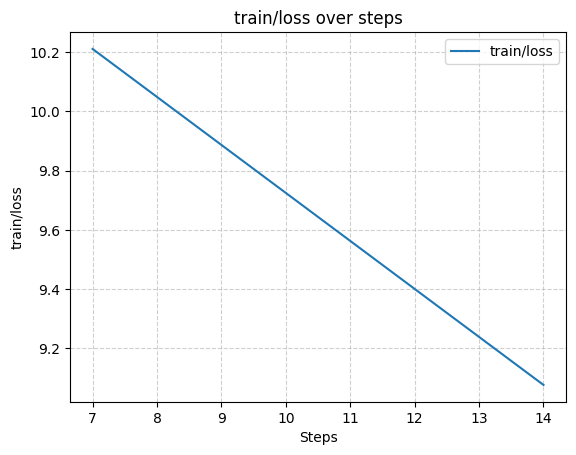

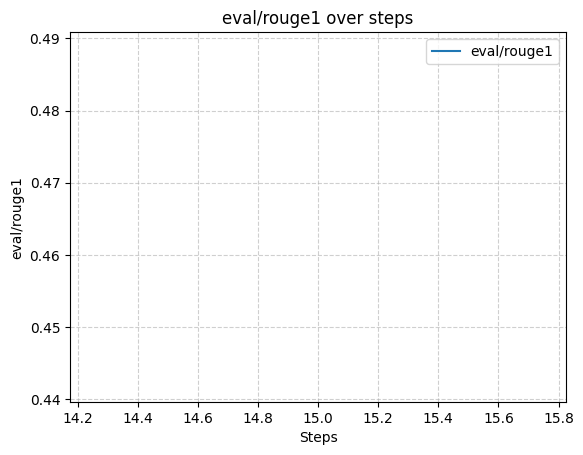

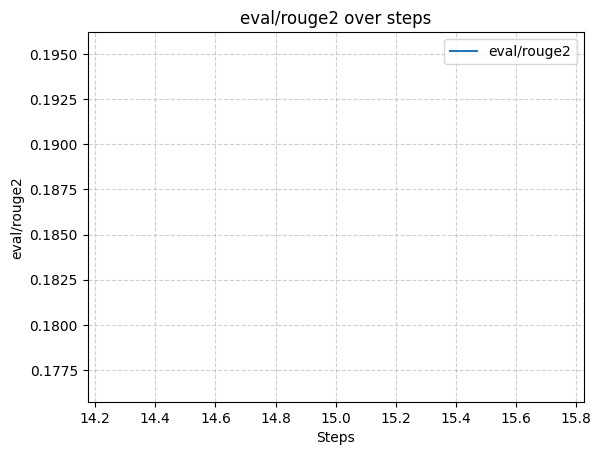

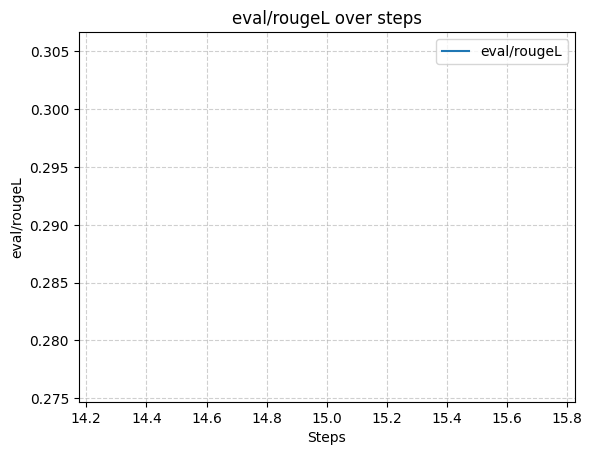

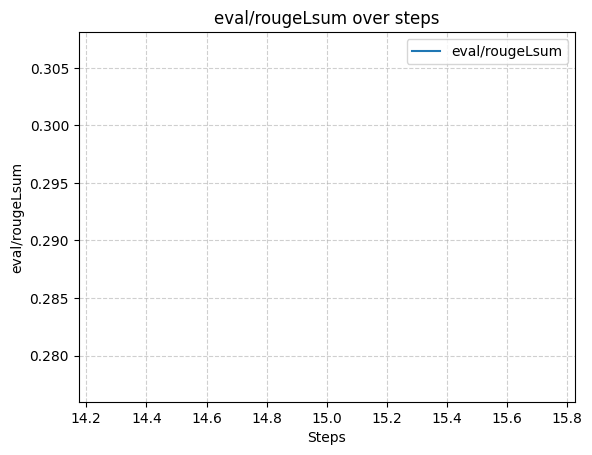

In [12]:
log_dir = LOG_DIR
event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if f.startswith("events")]

scalars = {}
for file in event_files:
    event_acc = EventAccumulator(file)
    event_acc.Reload()
    tags = event_acc.Tags()["scalars"]
    for tag in tags:
        events = event_acc.Scalars(tag)
        values = [event.value for event in events]
        steps = [event.step for event in events]
        if tag not in scalars:
            scalars[tag] = {"steps": steps, "values": values}
        else:
            scalars[tag]["steps"].extend(steps)
            scalars[tag]["values"].extend(values)

metrics_to_plot = ["train/loss", "eval/rouge1", "eval/rouge2", "eval/rougeL", "eval/rougeLsum"]

for metric in metrics_to_plot:
    if metric in scalars:
        steps = scalars[metric]["steps"]
        values = scalars[metric]["values"]

        sorted_pairs = sorted(zip(steps, values))
        steps, values = zip(*sorted_pairs)
        
        plt.plot(steps, values, label=metric)
        plt.xlabel("Steps")
        plt.ylabel(metric)
        plt.title(f"{metric} over steps")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    else:
        print(f"Metric {metric} not found in logs.")

In [13]:
def evaluate_rouge_on_test(model, tokenizer, test_dataset_raw, batch_size=4):
    import numpy as np
    from tqdm import tqdm
    
    model.eval()
    
    predictions = []
    references = []
    
    print(f"Đánh giá ROUGE trên {len(test_dataset_raw)} mẫu test...")
    
    for i in tqdm(range(0, len(test_dataset_raw), batch_size)):
        batch = test_dataset_raw.select(range(i, min(i + batch_size, len(test_dataset_raw))))
        
        batch_predictions = []
        batch_references = []
        
        for example in batch:
            input_text = example['Content']
            reference_summary = example['Summary']

            inputs = tokenizer.encode(
                input_text, 
                return_tensors="pt", 
                max_length=MAX_LEN, 
                truncation=True
            ).to(device)
            
            with torch.no_grad():
                outputs = model.generate(
                    inputs,
                    max_new_tokens=MAX_LEN // 4,
                    num_beams=4,
                    early_stopping=True,
                    no_repeat_ngram_size=2,
                    length_penalty=1.0,
                    do_sample=False,
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )
            
            # Decode prediction
            predicted_summary = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
            
            batch_predictions.append(predicted_summary)
            batch_references.append(reference_summary)
        
        predictions.extend(batch_predictions)
        references.extend(batch_references)
        
        if device.type == 'cuda':
            torch.cuda.empty_cache()
    
    rouge_results = rouge_metric.compute(
        predictions=predictions,
        references=references,
        use_stemmer=True
    )
    
    pred_lengths = [len(pred.split()) for pred in predictions]
    ref_lengths = [len(ref.split()) for ref in references]
    
    print("\n" + "="*50)
    print("KẾT QUẢ ĐÁNH GIÁ ROUGE TRÊN TẬP TEST")
    print("="*50)
    print(f"Số lượng mẫu test: {len(predictions)}")
    print(f"ROUGE-1: {rouge_results['rouge1']:.4f}")
    print(f"ROUGE-2: {rouge_results['rouge2']:.4f}")
    print(f"ROUGE-L: {rouge_results['rougeL']:.4f}")
    print(f"ROUGE-Lsum: {rouge_results['rougeLsum']:.4f}")
    print(f"Độ dài trung bình prediction: {np.mean(pred_lengths):.1f} từ")
    print(f"Độ dài trung bình reference: {np.mean(ref_lengths):.1f} từ")
    print(f"Tỷ lệ compression: {np.mean(pred_lengths) / np.mean(ref_lengths):.2f}")
    
    return {
        'rouge_scores': rouge_results,
        'predictions': predictions,
        'references': references,
        'pred_lengths': pred_lengths,
        'ref_lengths': ref_lengths
    }

In [14]:
def show_sample_results(results, num_samples=5):
    predictions = results['predictions']
    references = results['references']
    
    print("\n" + "="*50)
    print("MỘT SỐ VÍ DỤ KẾT QUẢ SUMMARIZATION")
    print("="*50)
    
    for i in range(min(num_samples, len(predictions))):
        print(f"\n--- VÍ DỤ {i+1} ---")
        print(f"Reference Summary:")
        print(f"{references[i]}")
        print(f"\nPredicted Summary:")
        print(f"{predictions[i]}")
        print(f"\nĐộ dài - Reference: {len(references[i].split())} từ, Predicted: {len(predictions[i].split())} từ")
        print("-" * 80)

results = evaluate_rouge_on_test(model, tokenizer, test_dataset_raw, batch_size=TEST_BATCH_SIZE)

show_sample_results(results, num_samples=5)

Đánh giá ROUGE trên 200 mẫu test...


100%|██████████| 100/100 [02:53<00:00,  1.73s/it]



KẾT QUẢ ĐÁNH GIÁ ROUGE TRÊN TẬP TEST
Số lượng mẫu test: 200
ROUGE-1: 0.4876
ROUGE-2: 0.2067
ROUGE-L: 0.3123
ROUGE-Lsum: 0.3121
Độ dài trung bình prediction: 29.7 từ
Độ dài trung bình reference: 38.1 từ
Tỷ lệ compression: 0.78

MỘT SỐ VÍ DỤ KẾT QUẢ SUMMARIZATION

--- VÍ DỤ 1 ---
Reference Summary:
Hình ảnh 15 chiếc ô tô tang vật, trong đó có đến 14 chiếc vận chuyển 50 tấn đường, được đưa vào trụ sở Công an H.Đakrông (Quảng Trị) hôm 29.10 thực sự làm nhiều người sốc vì quy mô của đường dây buôn lậu này.

Predicted Summary:
THANH LỘC - Hàng chục tấn đường nhập lậu trên những đoàn xe hạ tải phóng bạt mạng trên QL9 trong đêm tối bị phát giác, nhiều người không khỏi ngạc nhiên.

Độ dài - Reference: 46 từ, Predicted: 32 từ
--------------------------------------------------------------------------------

--- VÍ DỤ 2 ---
Reference Summary:
Giải đấu nhiều cảm xúc Vinpearl DIC Legends Việt Nam 2023 đã khép lại sau ngày thi đấu thứ ba (2.12), với chức vô địch thuộc về golfer người Brazil Adilson 

In [15]:
import gc
gc.collect()
torch.cuda.empty_cache()
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB")
    print(f"Memory Cached: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB")

Number of GPUs available: 2
GPU 0: Tesla T4
Memory Allocated: 2339.40 MB
Memory Cached: 2362.00 MB
GPU 1: Tesla T4
Memory Allocated: 0.00 MB
Memory Cached: 0.00 MB
